# __Predicting Perth Home Prices - The Value of Character__

<img src="https://i.redd.it/eiym87nwwo941.jpg" alt='Federation Style Home' width="400"><br>



The goal of this project is to better understand the __significance of certain features__ on a __property's price__ in the Perth Metropolitan Area (Western Australia), and conducting a comparison between __character homes__ and __new homes__. A home will be considered to be a character home if its year of construction was 1950 or earlier (guidelines for what constitutes a character home vary between city Councils, so having a common reference year will be used to simplify the analysis), and a new home is considered any home built after 1950.

Having worked in architecture for the last 5 years, it became clear that character homes can be (significantly) more expensive than newly built homes due to their historical significance, aesthetic character, and situation within established older suburbs. This study should help to substantiate this argument from a quantitative perspective using data.

The dataset being used was sourced from [Perth Housing Dataset](https://www.kaggle.com/syuzai/perth-house-prices) which contains data and features scraped from [Home Sold Price](http://house.speakingsame.com/).

__This study involves the following sections__:

1. Data Cleaning - Initial data overview, handling missing values
2. Exploratory Data Analysis - Visualizing distributions, handling outliers, feature relationship analysis
3. Machine Learning - Developing and evaluating a regression machine learning model for price predictions

## 💾 1. __Data Cleaning__

Let's begin by importing packages, getting an overview of the dataset, and identifying potential issues with the data.

In [1]:
# Import packages for numeric operations and working with structured data
import numpy as np
from numpy import int64
import pandas as pd

# Import visualization packages
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.pyplot import figure
import matplotlib
import seaborn as sns

# Import machine learning with sci-kit learn packages
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error as MSE

In [2]:
# Read in CSV file as a DataFrame and inspect first 5 rows
houses_df = pd.read_csv(r'all_perth_house_sales_310121.csv')
houses_df.head(5)

,ADDRESS,SUBURB,PRICE,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN,NEAREST_STN_DIST,DATE_SOLD,POSTCODE,LATITUDE,LONGITUDE,NEAREST_SCH,NEAREST_SCH_DIST,NEAREST_SCH_RANK
0,1 Acorn Place,South Lake,565000,4,2,2.0,600,160,2003.0,18300,Cockburn Central Station,1800,09-2018\r,6164,-32.115900,115.842450,LAKELAND SENIOR HIGH SCHOOL,0.828339,NaN
1,1 Addis Way,Wandi,365000,3,2,2.0,351,139,2013.0,26900,Kwinana Station,4900,02-2019\r,6167,-32.193470,115.859554,ATWELL COLLEGE,5.524324,129.0
2,1 Ainsley Court,Camillo,287000,3,1,1.0,719,86,1979.0,22600,Challis Station,1900,06-2015\r,6111,-32.120578,115.993579,KELMSCOTT SENIOR HIGH SCHOOL,1.649178,113.0
3,1 Albert Street,Bellevue,255000,2,1,2.0,651,59,1953.0,17900,Midland Station,3600,07-2018\r,6056,-31.900547,116.038009,SWAN VIEW SENIOR HIGH SCHOOL,1.571401,NaN
4,1 Aman Place,Lockridge,325000,4,1,2.0,466,131,1998.0,11200,Bassendean Station,2000,11-2016\r,6054,-31.885790,115.947780,KIARA COLLEGE,1.514922,NaN


The above reveals the dataset columns:

- <code>ADDRESS</code> : Property address in Perth
- <code>PRICE</code> : Price at which a property was sold (AUD)
- <code>BEDROOMS</code> : Number of bedrooms
- <code>BATHROOMS</code> : Number of bathrooms
- <code>GARAGE</code> : Number of parking spots
- <code>LAND_AREA</code> : Total land area (m^2)
- <code>FLOOR_AREA</code> : Internal floor area (m^2)
- <code>BUILD_YEAR</code> : Year of property's construction
- <code>CBD_DIST</code> : Distance to the central codeusiness district (CcodeD) of Perth (m)
- <code>NEAREST_STN</code> : Name of the nearest train station from the property
- <code>NEAREST_STN_DIST</code> : The nearest station distance (m)
- <code>DATE_SOLD</code> : Month & year of property's most recent sale
- <code>POSTCODE</code> : Local Area Identifier
- <code>LATITUDE</code> : Geographic Location (lat) of <code>ADDRESS</code>
- <code>LONGITIDE</code> : Geographic Location (long) of <code>ADDRESS</code>
- <code>NEAREST_SCH</code> : Name of nearest school
- <code>NEAREST_SCH_DIST</code> : Distance to the nearest school
- <code>NEAREST_SCH_RANK</code> : Ranking of the nearest school 

In [3]:
# Obtain DataFrame general information
houses_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33656 entries, 0 to 33655
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ADDRESS           33656 non-null  object 
 1   SUBURB            33656 non-null  object 
 2   PRICE             33656 non-null  int64  
 3   BEDROOMS          33656 non-null  int64  
 4   BATHROOMS         33656 non-null  int64  
 5   GARAGE            31178 non-null  float64
 6   LAND_AREA         33656 non-null  int64  
 7   FLOOR_AREA        33656 non-null  int64  
 8   BUILD_YEAR        30501 non-null  float64
 9   CBD_DIST          33656 non-null  int64  
 10  NEAREST_STN       33656 non-null  object 
 11  NEAREST_STN_DIST  33656 non-null  int64  
 12  DATE_SOLD         33656 non-null  object 
 13  POSTCODE          33656 non-null  int64  
 14  LATITUDE          33656 non-null  float64
 15  LONGITUDE         33656 non-null  float64
 16  NEAREST_SCH       33656 non-null  object

In [4]:
# Remove the suffix "\r" from all the DATE_SOLD string values to keep only the Month and Year
houses_df['DATE_SOLD'] = houses_df['DATE_SOLD'].map(lambda x: x.rstrip('\r'))

# Extract just the years from the DATE_SOLD column into a list, then print them in a string
year_sold = pd.DatetimeIndex(houses_df['DATE_SOLD']).year
print(f'The dataset contains properties that were sold between the years of {year_sold.min()} and year {year_sold.max()}')

# Check dataset for duplicates
number_dup = houses_df[houses_df.duplicated()].shape[0]
print(f'\nThe total number of duplicates is {str(number_dup)}  \n')

# Print a Pandas Series showing any columns containing missing values and the respective missing value sum for that column
col_with_na = houses_df.isna().sum().sort_values(ascending = False)
col_with_na_only = col_with_na[col_with_na > 0]

# Create column with the percentage 
col_with_na_only_perc = (round((col_with_na_only/len(houses_df)),4) * 100).map('{:.2f}%'.format)

# Combine the count of missing values with the percent
combined_missing = pd.concat([col_with_na_only, col_with_na_only_perc], axis=1).rename(columns = {0: 'Sum of missing values', 1: 'Percentage of total'})
combined_missing.head()

The dataset contains properties that were sold between the years of 1988 and year 2020

The total number of duplicates is 0  



,Sum of missing values,Percentage of total
NEAREST_SCH_RANK,10952,32.54%
BUILD_YEAR,3155,9.37%
GARAGE,2478,7.36%


### __Data Overview Findings__

- The dataset consists of 33,656 observations, each relating to a unique property sale (each corresponds to a distinct address).
- Dataset includes property sales between the years of 1988 and 2020
- There are missing values in 3 columns <code>BUILD_YEAR</code>, <code>GARAGE</code> and <code>NEAREST_SCH_RANK</code> which we will be addressing next with different methods.

### __Imputing missing BUILD_YEAR values__ 

Let's start by imputing the missing values for <code>BUILD_YEAR</code> with each observation suburb's <code>BUILD_YEAR</code> mode. Imputing the missing values with the <code>BUILD_YEAR</code> of the corresponding suburb, as opposed to the mode in the whole dataset, ensures the values are consistent with the most frequent construction year observed for other surrounding properties of the suburb.

Before imputing, we will first take a sample from the DataFrame that currently has observations containing these missing values, which we will use to check against after the imputing operation.

In [5]:
# Select a sample of 5 rows which currently have a missing "BUILD_YEAR" to check against these after imputing
houses_df_buildyearna = houses_df[houses_df['BUILD_YEAR'].isna()]
houses_df_buildyearna_sample = houses_df_buildyearna.sample(5, random_state=42)

# Store list of addresses from sample
sample_address_list = houses_df_buildyearna_sample['ADDRESS'].unique()

# Store list of suburbs from sample
sample_suburb_list = houses_df_buildyearna_sample['SUBURB'].unique()

# Print the stored sample data
print(sample_suburb_list)
houses_df_buildyearna_sample.head()

['Roleystone' 'Greenmount' 'Waterford' 'Two Rocks' 'Gooseberry Hill']


,ADDRESS,SUBURB,PRICE,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN,NEAREST_STN_DIST,DATE_SOLD,POSTCODE,LATITUDE,LONGITUDE,NEAREST_SCH,NEAREST_SCH_DIST,NEAREST_SCH_RANK
32749,9 Moseri Road,Roleystone,655000,4,2,2.0,2000,266,NaN,27000,Kelmscott Station,7000,10-2018,6111,-32.099875,116.086271,JOHN WOLLASTON ANGLICAN COMMUNITY SCHOOL,7.410203,40.0
29105,7 Innamincka Road,Greenmount,677500,3,2,6.0,1864,202,NaN,19000,Midland Station,4900,11-2017,6056,-31.900840,116.051120,SWAN VIEW SENIOR HIGH SCHOOL,1.618359,NaN
31846,84 Waterford Avenue,Waterford,1210000,5,2,3.0,834,287,NaN,7600,Canning Bridge Station,3200,01-2014,6152,-32.014840,115.889510,CLONTARF ABORIGINAL COLLEGE,0.338425,NaN
33276,93 Harvest Circle,Two Rocks,854000,4,2,2.0,10867,227,NaN,58700,Butler Station,20500,01-2017,6037,-31.457450,115.645760,YANCHEP SECONDARY COLLEGE,10.577264,NaN
1450,10 The Getaway,Gooseberry Hill,1070000,3,1,NaN,2693,273,NaN,17300,Midland Station,8500,01-2020,6076,-31.959960,116.041640,KALAMUNDA SENIOR HIGH SCHOOL,2.420186,107.0


In [6]:
# Get total observations with missing BUILD_YEAR
houses_buildyear_nan = houses_df['BUILD_YEAR'].isna().sum()
print(f'\nThe total amount of houses with "NaN" as their build year in the original dataset is {houses_buildyear_nan}')

# Impute observations with missing BUILD_YEAR values with their respective suburb's BUILD_YEAR mode
houses_df['BUILD_YEAR'] = houses_df.groupby('SUBURB')['BUILD_YEAR'].apply(lambda x: x.fillna(x.mode().mean()))

# Check the number of missing BUILD_YEAR values following above operation
houses_buildyear_nan_after = houses_df['BUILD_YEAR'].isna().sum()
print(f'\nThe total amount of houses with "NaN" as their build year after imputation 1 is {houses_buildyear_nan_after}')

# Impute any remaining observations that don't have a suburb BUILD_YEAR mode with the dataset's BUILD_YEAR mode
houses_df['BUILD_YEAR'] = houses_df['BUILD_YEAR'].fillna(houses_df['BUILD_YEAR'].mode()[0])
houses_buildyear_nan_final = houses_df['BUILD_YEAR'].isna().sum()

# Check that the number of missing BUILD_YEAR values is zero
print(f'\nThe total amount of houses with "NaN" as their build year after imputation 2 is {houses_buildyear_nan_final}')


The total amount of houses with "NaN" as their build year in the original dataset is 3155

The total amount of houses with "NaN" as their build year after imputation 1 is 6

The total amount of houses with "NaN" as their build year after imputation 2 is 0


In [7]:
# Print the suburb BUILD_YEAR mode for the suburbs in the sample
for suburb in sample_suburb_list:
    suburb_buildyear_mode = houses_df[houses_df['SUBURB']==suburb]['BUILD_YEAR'].mode()[0].astype(int)
    print(f'The most frequent "BUILD_YEAR" value of {suburb} is {suburb_buildyear_mode}')

# Verify that the observations from the original sample now have the suburbs' BUILD_YEAR mode values
houses_df_buildyearfilled_sample = houses_df[houses_df['ADDRESS'].isin(sample_address_list)]
houses_df_buildyearfilled_sample.head()

The most frequent "BUILD_YEAR" value of Roleystone is 1985
The most frequent "BUILD_YEAR" value of Greenmount is 1989
The most frequent "BUILD_YEAR" value of Waterford is 1996
The most frequent "BUILD_YEAR" value of Two Rocks is 1989
The most frequent "BUILD_YEAR" value of Gooseberry Hill is 1970


,ADDRESS,SUBURB,PRICE,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN,NEAREST_STN_DIST,DATE_SOLD,POSTCODE,LATITUDE,LONGITUDE,NEAREST_SCH,NEAREST_SCH_DIST,NEAREST_SCH_RANK
1450,10 The Getaway,Gooseberry Hill,1070000,3,1,NaN,2693,273,1970.0,17300,Midland Station,8500,01-2020,6076,-31.959960,116.041640,KALAMUNDA SENIOR HIGH SCHOOL,2.420186,107.0
29105,7 Innamincka Road,Greenmount,677500,3,2,6.0,1864,202,1989.0,19000,Midland Station,4900,11-2017,6056,-31.900840,116.051120,SWAN VIEW SENIOR HIGH SCHOOL,1.618359,NaN
31846,84 Waterford Avenue,Waterford,1210000,5,2,3.0,834,287,1996.0,7600,Canning Bridge Station,3200,01-2014,6152,-32.014840,115.889510,CLONTARF ABORIGINAL COLLEGE,0.338425,NaN
32749,9 Moseri Road,Roleystone,655000,4,2,2.0,2000,266,1985.0,27000,Kelmscott Station,7000,10-2018,6111,-32.099875,116.086271,JOHN WOLLASTON ANGLICAN COMMUNITY SCHOOL,7.410203,40.0
33276,93 Harvest Circle,Two Rocks,854000,4,2,2.0,10867,227,1989.0,58700,Butler Station,20500,01-2017,6037,-31.457450,115.645760,YANCHEP SECONDARY COLLEGE,10.577264,NaN


The above output demonstrates <code>BUILD_YEAR</code> has been successfully imputed with the previously outlined method.

### __Imputing missing GARAGE values__ 

Let's now impute GARAGE values. First, let's visualize the discrete distribution of Garage values with the help of a histogram.

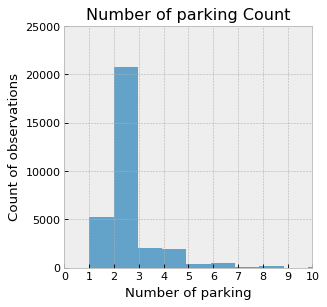

In [8]:
# Set plotting style
plt.style.use('bmh')

# Set figure size
figure(figsize=(4, 4), dpi=80)

# Plot histogram of garage number vs count of garage number
plt.hist(houses_df['GARAGE'], bins=100, alpha=0.75)

# Limit to 10 along x-axis to focus on most frequent values
plt.xlim([0, 10])
plt.ylim([0, 25000])

# Allow 10 ticks for x-axis
plt.locator_params(axis='x', nbins=10)

# Edit and format graph
plt.title('Number of GARAGE frequency')
plt.xlabel('Number of parking')
plt.ylabel('Count of observations')
plt.title('Number of parking Count')
plt.show()

Given the most common GARAGE value is 2 in the whole dataset, for simplification, we will impute 2 for all GARAGE missing values.

In [9]:
# Get total observations with missing GARAGE
houses_garage_nan = houses_df['GARAGE'].isna().sum()
print(f'\nThe total amount of houses with "NaN" as their garage value in the original dataset is {houses_garage_nan}')

# Impute observations with missing GARAGE values with the GARAGE mode value
houses_df['GARAGE'] = houses_df['GARAGE'].fillna(houses_df['GARAGE'].mode()[0])

# Check that the number of missing GARAGE values is zero
houses_garage_nan_after = houses_df['GARAGE'].isna().sum()
print(f'\nThe total amount of houses with "NaN" as their garage value after imputation is {houses_garage_nan_after}')


The total amount of houses with "NaN" as their garage value in the original dataset is 2478

The total amount of houses with "NaN" as their garage value after imputation is 0


### Addressing missing NEAREST_SCH_RANK values

As <code>NEAREST_SCH_RANK</code> was found to have almost 1/3 of its values missing (10952 values) and that it will be difficult to ascertain the ranks of all schools (moreover, a ranking that gets updated periodically) this column will be removed from the DataFrame. It is worth noting, however, that the <code>NEAREST_SCHOOL</code> column, which is complete, should compensate for the lack of a school rank column in a machine learning model, as the schools should reflect its corresponding school rank.

In [10]:
# Remove NEAREST_SCH_RANK from DataFrame
houses_df = houses_df.drop('NEAREST_SCH_RANK', axis=1)

# Check removal
houses_df.head(3)

,ADDRESS,SUBURB,PRICE,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN,NEAREST_STN_DIST,DATE_SOLD,POSTCODE,LATITUDE,LONGITUDE,NEAREST_SCH,NEAREST_SCH_DIST
0,1 Acorn Place,South Lake,565000,4,2,2.0,600,160,2003.0,18300,Cockburn Central Station,1800,09-2018,6164,-32.115900,115.842450,LAKELAND SENIOR HIGH SCHOOL,0.828339
1,1 Addis Way,Wandi,365000,3,2,2.0,351,139,2013.0,26900,Kwinana Station,4900,02-2019,6167,-32.193470,115.859554,ATWELL COLLEGE,5.524324
2,1 Ainsley Court,Camillo,287000,3,1,1.0,719,86,1979.0,22600,Challis Station,1900,06-2015,6111,-32.120578,115.993579,KELMSCOTT SENIOR HIGH SCHOOL,1.649178


In [11]:
# Let's convert the data type of the GARAGE and BUILD_YEAR columns to integers as these are whole numbers
houses_df['GARAGE'] = houses_df['GARAGE'].astype(int64)
houses_df['BUILD_YEAR'] = houses_df['BUILD_YEAR'].astype(int64)

## 🔎 2. __Exploratory Data Analysis__

Now that missing values have been addressed, let's explore and visualize the data in more detail.

### __Analysing Price Distribution__

As we are also interested in a comparative analysis between older homes (properties built during or before 1950) and newer homes (properties built after 1950), we will first subset the DataFrame to create two additional DataFrames.

Then we will create plots of property <code>PRICE</code> to get a better idea of the distribution of values in the 3 DataFrames.

In [12]:
# Subset new homes DataFrame
houses_post_1950_df = houses_df[houses_df['BUILD_YEAR']>1950]

# Subset character homes DataFrame
houses_pre_1950_df = houses_df[houses_df['BUILD_YEAR']<=1950]

# Print out number of DataFrame rows for new homes
print(f'The dataset contains {len(houses_post_1950_df)} properties built after 1950')

# Print out number of DataFrame rows for new homes
print(f'The dataset contains {len(houses_pre_1950_df)} properties built during or before 1950')

The dataset contains 31594 properties built after 1950
The dataset contains 2062 properties built during or before 1950


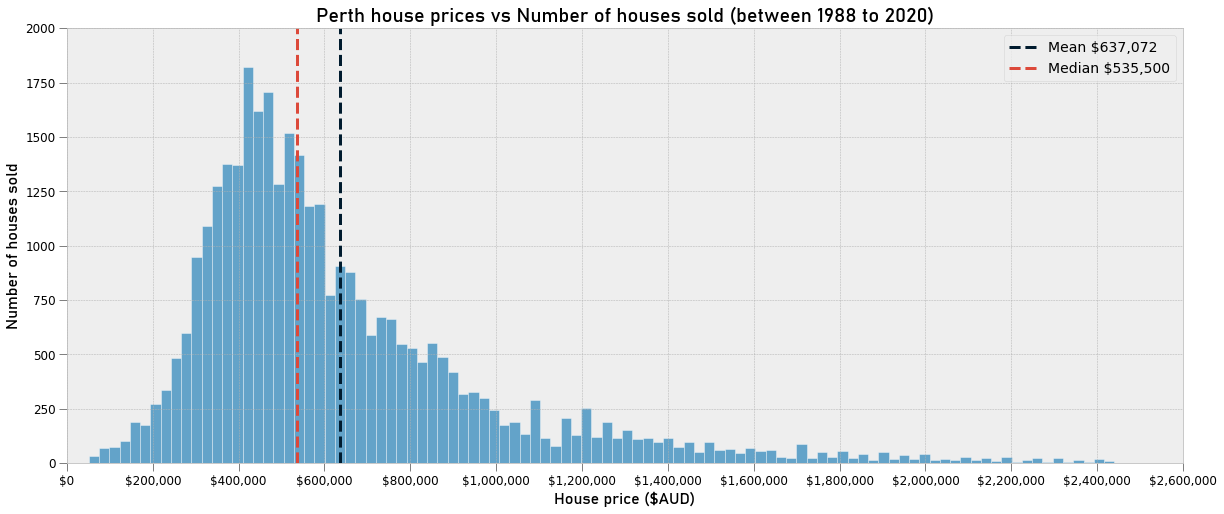

In [13]:
# Set plotting style
plt.style.use('bmh')

# Create figure and axis object
fig, ax = plt.subplots()

# Create fonts
tfont = {'fontname':'Bahnschrift', 'weight':'bold', 'size':20}
lfont = {'fontname':'Bahnschrift', 'weight':'regular', 'size':16}

# Set figure size
fig.set_size_inches(20,8)

# Plot histogram of houses_df PRICE distribution
ax.hist(houses_df['PRICE'], bins=100, edgecolor='white', alpha=0.75)

# Set labels
ax.set_xlabel('House price ($AUD)', lfont)
ax.set_ylabel('Number of houses sold', lfont)
ax.set_title('Perth house prices vs Number of houses sold (between 1988 to 2020)', tfont)

# Format plot ticks
ax.tick_params(bottom=True, left=True, length=8, width=1, which='major', direction='out', color='grey', labelsize=12)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: '$' + format(x,',')))
ax.set_ylim([0, 2000])
ax.set_xlim([0, max(houses_df['PRICE'])])
ax.set_xticks(np.arange(0, 2700000, 200000))
ax.locator_params(axis='x', nbins=100)

# Add vertical lines indicating mean and median 
ax.axvline(houses_df['PRICE'].mean(), color='#001B2E', linestyle='dashed', linewidth=3, label=f"Mean ${format(round(houses_df['PRICE'].mean()), ',')}")
ax.axvline(houses_df['PRICE'].median(), color='#DC493A', linestyle='dashed', linewidth=3, label=f"Median ${format(round(houses_df['PRICE'].median()), ',')}")

# Add legend for vertical lines
ax.legend(prop={'size':14})

plt.show()

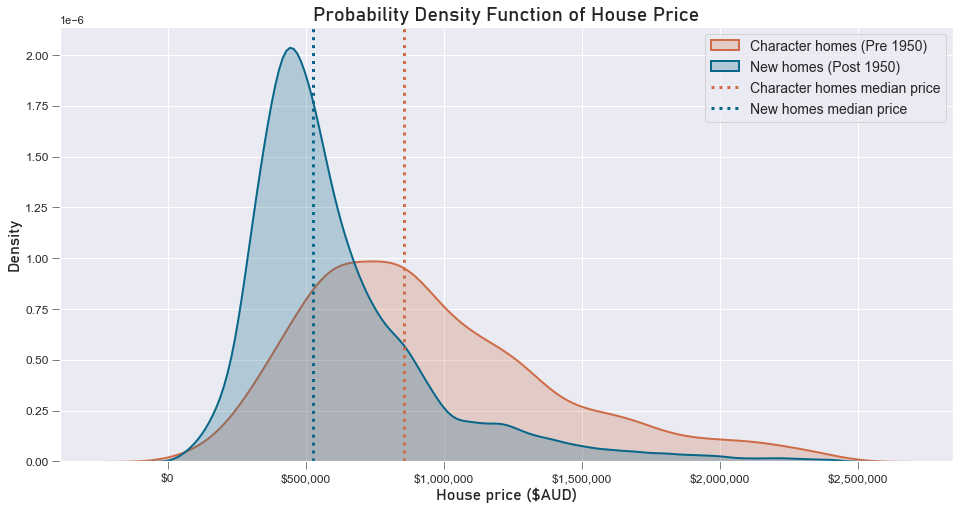

In [14]:
# Set figure size
sns.set(rc={'figure.figsize':(16,8)})

# Plot Kernel Density Estimation of PRICE distribution
ax = sns.kdeplot(houses_pre_1950_df['PRICE'], color='#CE6C47', linewidth=2, fill=True, label='Character homes (Pre 1950)')
ax = sns.kdeplot(houses_post_1950_df['PRICE'], color='#086788', linewidth=2, fill=True, label='New homes (Post 1950)')

# Set labels
ax.set_xlabel('House price ($AUD)', lfont)
ax.set_ylabel('Density', lfont)
ax.set_title('Probability Density Function of House Price', tfont)

# Format plot ticks
ax.tick_params(bottom=True, left=True, length=8, width=1, which='major', direction='out', color='grey', labelsize=12)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: '$' + format(round(x), ',')))

# Add vertical lines indicating mean and median 
ax.axvline(houses_pre_1950_df['PRICE'].median(), color='#CE6C47', linestyle='dotted', linewidth=3, label='Character homes median price')
ax.axvline(houses_post_1950_df['PRICE'].median(), color='#086788', linestyle='dotted', linewidth=3, label='New homes median price')

# Add legend for vertical lines
ax.legend(prop={'size':14})

plt.show()

### __Insights on PRICE Distribution__

- The two newly created datasets derived from the __houses_df__ DataFrame have different numbers of observations with __houses_pre_1950_df__ having 2,062 observations, and __houses_post_1950_df__ having 31,594, which makes sense given the construction of properties has increased with the passing of time to meet growing population numbers.

- The <code>PRICE</code> feature is right skewed and not normally distributed, with probabilities tapering off more slowly for expensive homes.

- Most property prices in the dataset sit between \$400,000 and \$450,000, with a median of $535,500.

- Character homes are generally more expensive than New homes, with a greater proportion of homes in the dataset having a higher price tag. The median price of a character home is also notably higher than a new home.

### __Feature Distribution and Outlier Detection__

Let's better understand the distribution of other features in the data, see if there are any abnormal values, and address these abnormalities.

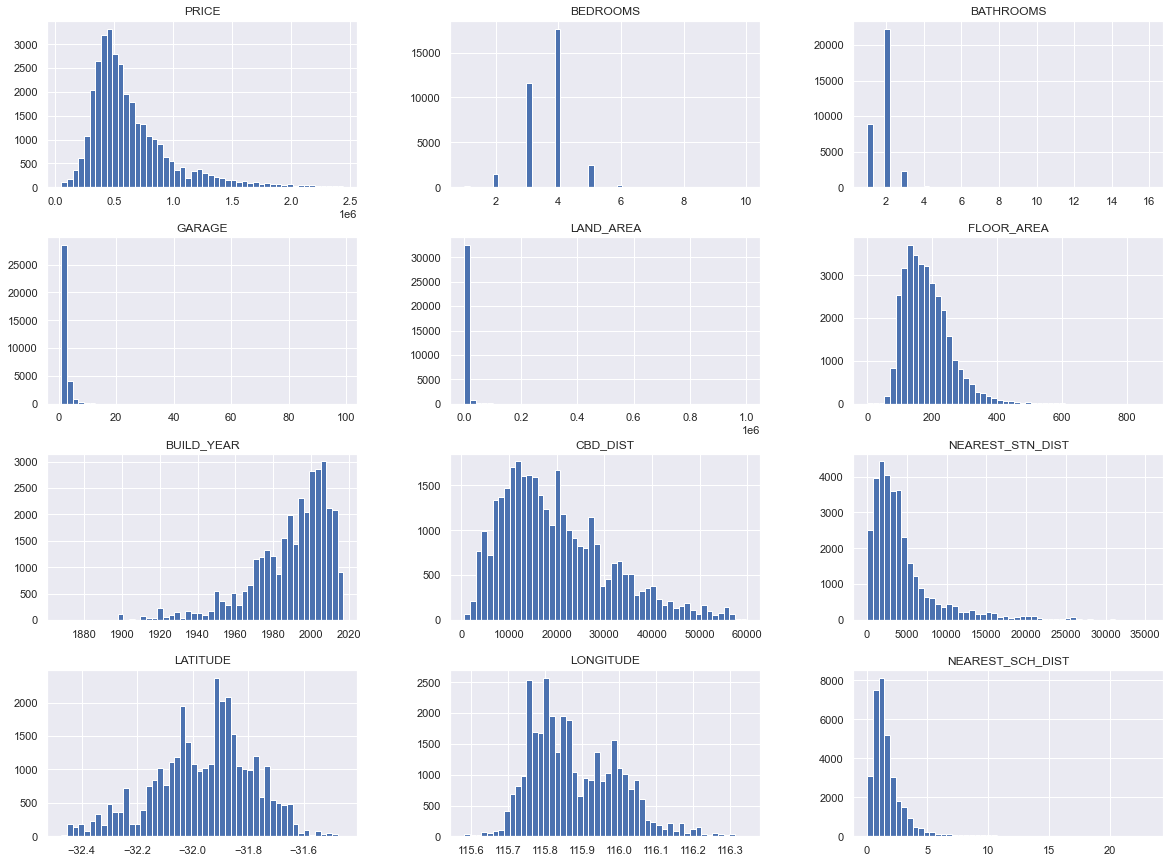

In [15]:
# Select only features with numerical values
num_columns_only = houses_df.select_dtypes(['int64', 'float64']).drop('POSTCODE', axis=1)

# Plot histograms for each feature to understand distribution
num_columns_only.hist(bins = 50, figsize=(20,15))

plt.show()

In [16]:
# Define function to get 10 largest values of a column
def largest_num_in_col(dfcolumn, df=houses_df):
    largest_10 = houses_df[dfcolumn].nlargest(10).values
    return largest_10

# Create empty dictionary to store column name as key, and 10 largest values as values
dict_largest_val = {}

# Append dictionary with each column from numerical features name and 10 largest values of that column
for col in num_columns_only.columns:
    key = col
    dict_largest_val[key] = largest_num_in_col(col)

# Create DataFrame from dictionary
largest_val_df = pd.DataFrame(dict_largest_val)

largest_val_df.head(10)

,PRICE,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN_DIST,LATITUDE,LONGITUDE,NEAREST_SCH_DIST
0,2440000,10,16,99,999999,870,2017,59800,35500,-31.457450,116.343201,23.254372
1,2437000,10,7,50,999999,849,2017,59800,35500,-31.462553,116.341780,20.720911
2,2430000,9,7,32,999999,840,2017,59400,35100,-31.464280,116.340230,19.406233
3,2425000,9,6,31,983690,830,2017,59400,35100,-31.465818,116.339340,19.325971
4,2425000,9,6,26,566786,808,2017,59400,34900,-31.468400,116.335869,19.142508
5,2425000,9,6,22,496919,806,2017,59200,34900,-31.469900,116.325740,18.337047
6,2425000,8,6,21,468086,800,2016,58700,34300,-31.471050,116.317640,18.272020
7,2425000,8,6,20,455212,764,2016,58100,34200,-31.472623,116.317600,17.908836
8,2420000,8,6,20,435187,761,2016,58000,34100,-31.476406,116.315400,17.766931
9,2410000,8,6,20,405000,751,2016,58000,33800,-31.477918,116.315090,17.594788


In [17]:
# Clip abnormal LAND_AREA outliers to a more reasonable value indicated by the next largest values
houses_df['LAND_AREA'] = houses_df['LAND_AREA'].clip(0, 566786)

# Clip abnormal GARAGE outliers to a more reasonable value indicated by the next largest values
houses_df['GARAGE'] = houses_df['GARAGE'].clip(0, 32)

# Check for largest values for the features
print(houses_df['LAND_AREA'].nlargest(5))
print(houses_df['GARAGE'].nlargest(5))

2684     566786
3575     566786
4261     566786
16791    566786
27619    566786
Name: LAND_AREA, dtype: int64
2122     32
17286    32
30286    32
32789    31
25632    26
Name: GARAGE, dtype: int64


### __Insights on Feature Distribution & Outlier Handling__

- The histograms for the numerical features of the dataset indicate that there exist some valid and some invalid extreme values in the dataset. Plotting them in the context of a DataFrame showcases that <CODE>GARAGE</CODE> and <CODE>LAND_AREA</CODE> both contain values that are likely incorrect outliers, with 99 and 999999 respectively, which are arbitrary and abnormally large values when compared to the set of largest values that follows.

- Although other values are similarly very large, they denote rural properties which have massive land areas, and consequently a much larger value for other features.

- In order to address the above incorrect outliers, they have been "capped" at the next largest reasonable outlier values from the data. Another option that could also be explored here would also be to drop these observations entirely.

### __Feature correlation with PRICE__

Which features from the dataset have the strongest correlation with price? Let's investigate...

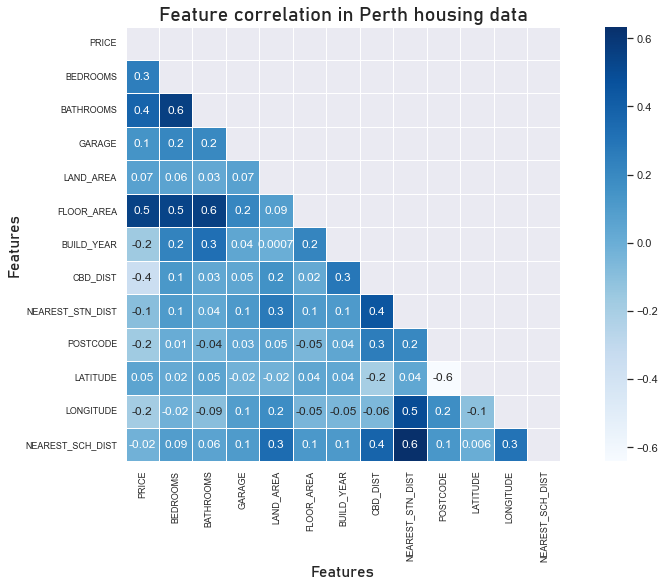

In [18]:
# Create figure and axis object and set figure size
fig, ax = plt.subplots()

# Create a mask to omit top right triangle in heatmap plot
corr = houses_df.corr(method = 'pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot heatmap of correlations between houses_df features
sns.heatmap(houses_df.corr(), annot=True, fmt='.1g', linewidth=.5, cmap='Blues', cbar=True, square=True, mask=mask)

# Set tick formatting
ax.tick_params('both', length=5, width=1, which='major', direction='out', color='grey', labelsize=9)

# Set labels
ax.set_xlabel('Features', lfont)
ax.set_ylabel('Features', lfont)
ax.set_title('Feature correlation in Perth housing data', tfont)

plt.show()

In [19]:
# Name the 3 DataFrames
houses_df.name = 'All Houses'
houses_pre_1950_df.name = 'Pre 1950 Houses'
houses_post_1950_df.name = 'Post 1950 Houses'

# Create list of DataFrames
df_list = [houses_df, houses_post_1950_df, houses_pre_1950_df]

# Create function to get correlation between PRICE and the features of each DataFrame
def getcorr(df, column='PRICE'):
    corr_w_target = df[df.columns].corr()[column]
    return(corr_w_target)

# Create empty dictionary to store DataFrame feature correlations with price
dict = {}

# Store DataFrame name and its correlations with PRICE in dictionary
for df in df_list:
    key = df.name
    dict[key] = getcorr(df)

print('Correlation of features with property price')

# Create DataFrame from dictionary and output
dataframe_corr_target = pd.DataFrame(dict).drop('PRICE').transpose()
dataframe_corr_target.head()

Correlation of features with property price


,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN_DIST,POSTCODE,LATITUDE,LONGITUDE,NEAREST_SCH_DIST
All Houses,0.252637,0.377133,0.143853,0.069482,0.548497,-0.168461,-0.354327,-0.095089,-0.171553,0.053041,-0.183734,-0.021941
Post 1950 Houses,0.279201,0.406049,0.142013,0.064631,0.580373,-0.023100,-0.323448,-0.063689,-0.148998,0.059960,-0.167003,-0.001771
Pre 1950 Houses,0.405754,0.465064,0.073666,-0.004433,0.554475,-0.117400,-0.372928,-0.249487,-0.272977,-0.046794,-0.505711,-0.132659


### __Insights on Feature Correlation__

- A house's <CODE>PRICE</CODE> generally has the strongest correlation with <CODE>FLOOR_AREA</CODE>, followed by the number of <CODE>BATHROOMS</CODE> then number of <CODE>BEDROOMS</CODE>. All of these are indicators of the size of the house, and their positive correlation with <CODE>PRICE</CODE> suggests that larger houses with additional rooms are (understandably) more expensive.

- <code>BUILD_YEAR</code> has also been shown to have a weak negative correlation with house price, which indicate that older homes generally have slightly higher prices.

- The correlation of features with <code>PRICE</code> is fairly consistent in the different DataFrames, although <code>BEDROOMS</code> has a higher correlation with <code>PRICE</code> in older homes.

### __Comparing PRICE as a function of FLOOR_AREA in older and newer homes__

Below the impact of the <code>FLOOR_AREA</code> feature, which has been found to have the highest correlation with <code>PRICE</code>, is analyzed further in relation to older and newer homes.

In [20]:
# Check number of of unique suburbs in houses_pre_1950_df
houses_pre_1950_df_sub = len(houses_pre_1950_df['SUBURB'].unique())
print(f'The DataFrame containing only character homes has {houses_pre_1950_df_sub} unique suburbs.')

# Check number of of unique suburbs in houses_post_1950_df
houses_post_1950_df_sub = len(houses_post_1950_df['SUBURB'].unique())
print(f'The DataFrame containing only newer homes has {houses_post_1950_df_sub} unique suburbs.')

# Group the DataFrames by SUBURB and take the mean for later EDA
houses_pre_1950_df_grouped = houses_pre_1950_df.groupby('SUBURB').mean()
houses_post_1950_df_grouped = houses_post_1950_df.groupby('SUBURB').mean()

The DataFrame containing only character homes has 154 unique suburbs.
The DataFrame containing only newer homes has 321 unique suburbs.


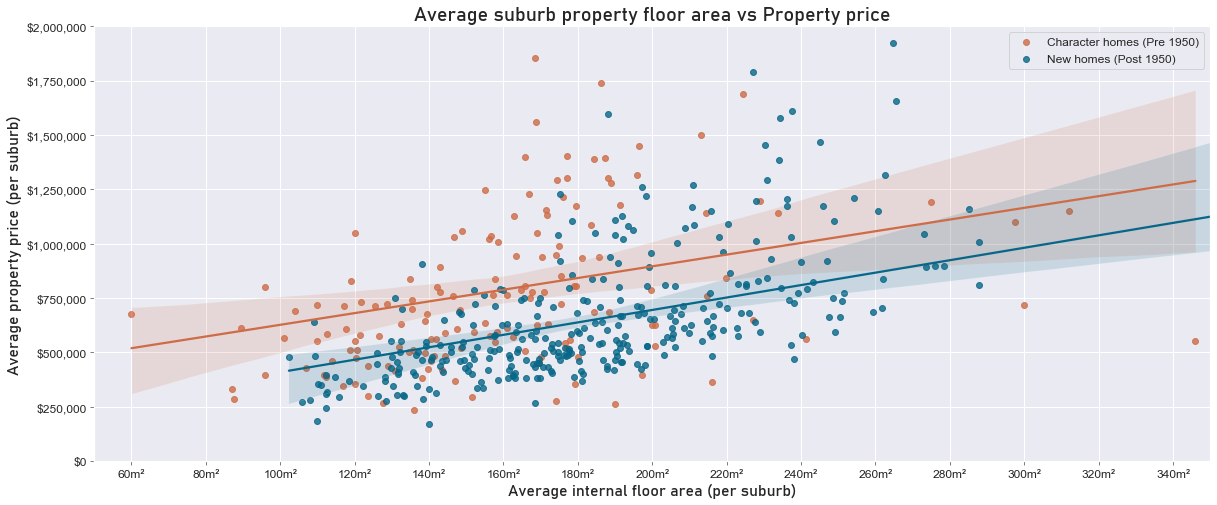

In [21]:
# Create figure and axis object
fig, ax = plt.subplots()

# Set figure size
fig.set_size_inches(20,8)

# Plot scatterplots with a linear regression model fit
sns.regplot(x='FLOOR_AREA', y='PRICE', data=houses_pre_1950_df_grouped, color='#CE6C47', label='Character homes (Pre 1950)', scatter_kws={'alpha':0.8})
sns.regplot(x='FLOOR_AREA', y='PRICE', data=houses_post_1950_df_grouped, color='#086788', label='New homes (Post 1950)', scatter_kws={'alpha':0.8})
ax.set_xlabel('Average internal floor area (per suburb)', lfont)
ax.set_ylabel('Average property price (per suburb)', lfont)
ax.set_title('Average suburb property floor area vs Property price', tfont)

# Format plot ticks
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: '$' + format(int(x), ',')))
ax.xaxis.set_major_formatter(FormatStrFormatter('%dm\u00b2'))
ax.tick_params(bottom=True, left=True, length=4, width=1, which='major', direction='out', color='grey', labelsize=12)
ax.locator_params(axis='x', nbins=20)

# Set x and y range limit to focus on main grouping of points
ax.set_ylim(0, 2000000)
ax.set_xlim(50, 350)

# Add legend for colour coding of DataFrames
ax.legend(prop={'size':12})

plt.show()

### __Insights on the impact of Floor Area on Price__

- Larger homes are generally more expensive.

- Character homes on average have higher prices than new homes of the same size. This is captured through how the blue dots are generally located below the orange dots (i.e. new homes have lower price), yet they share the same or very similar floor area. The linear regression model fit further solidifies this.

- Therefore, the price per square metre of an older home is generally higher than that of a new home.

## 🎯 3. __Machine Learning__

In this final section, a machine learning regression model for price prediction of Perth properties will be developed and evaluated.

### __Developing and Evaluating Machine Learning Model__

First let's prepare the data for the purposes of machine learning by ensuring all categorical features are expressed numerically, removing redundant features, and setting up explanatory and target variable sets. Then, let's scale the data to ensure they work across a common scale without distorting the differences in the range of values, and train and test different ensemble models on this data to compare how different learning methods perform. 

In [22]:
# Create Series of target variable PRICE
houses_df_target = houses_df['PRICE']

# Keep only SUBURB and POSTCODE features related to the location of a property
houses_df_prep = houses_df.drop(['ADDRESS', 'PRICE', 'LATITUDE', 'LONGITUDE'], axis=1)

# Convert categorical variables from explanatory variables into indicator/dummy variables
houses_df_predictor = pd.get_dummies(houses_df_prep, drop_first=True)

In [23]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(houses_df_predictor, houses_df_target, test_size=0.2, random_state=10)

# Instantiate models with default parameters to be evaluated
models = {
    'AdaBoostRegressor': AdaBoostRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor() 
    }

# Create empty lists to store performance metrics from each model
rmse_results = []
r2_results = []
model_names = []

# Fit, train and test each model on the data sets
for name, model in models.items():

    # Set up pipeline steps
    steps = [('scaler', StandardScaler()),
            (name, model)]
    
    # Create the pipeline: pipeline
    pipeline = Pipeline(steps)

    # Fit and train model with the training data, predict on test set, obtain performance scores
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    rmse_score = np.sqrt(MSE(y_test, y_pred))
    r2_score = pipeline.score(X_test, y_test)
    
    # Append performance metric in relevant list
    rmse_results.append(rmse_score)
    r2_results.append(r2_score)
    model_names.append(name)

# Create DataFrame from above lists
ml_results = pd.DataFrame([model_names, rmse_results, r2_results]).transpose()

# Rename results DataFrame columns for clarity
ml_results = ml_results.rename(columns={0:'Model Name', 1:'RMSE', 2:'R2 Score'}).sort_values('R2 Score', ascending=False)

# Check results
ml_results.head()

,Model Name,RMSE,R2 Score
1,RandomForestRegressor,152914.714614,0.810215
2,GradientBoostingRegressor,171743.401799,0.7606
0,AdaBoostRegressor,274057.196448,0.390397


In [24]:
# Set up pipeline steps
steps = [('scaler', StandardScaler()),
        ('RFR', RandomForestRegressor())]

# Set up cross validation parameters
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Instantiate pipeline object with steps
pipeline = Pipeline(steps)

# Set up hyper-parameters to test data on
params_rf = {
            'RFR__n_estimators': [100, 150, 200],
            'RFR__max_depth' : [50, 100, None]
            }

# Set up cross validation grid with pipeline, hyper-parameters, and KFold 
grid_rf = GridSearchCV(estimator=pipeline, param_grid=params_rf, cv=kf, n_jobs=-1)

# Fit the training data to the cross validation grid
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('RFR', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'RFR__max_depth': [50, 100, None],
                         'RFR__n_estimators': [100, 150, 200]})

In [25]:
# Get best model hyper-parameters: best_hyperparams
best_hyperparams = grid_rf.best_params_

# Get best model from grid search: best_model
best_model = grid_rf.best_estimator_

# Test best model on hold-out test: y-pred
y_pred = best_model.predict(X_test)

# Get RMSE by comparing the best model y_pred with actual y_test: rmse_test
rmse_test = np.sqrt(MSE(y_test, y_pred))

# Print model scores
print('Best hyperparameters:', best_hyperparams)
print('R-squared score: ' + str(best_model.score(X_test, y_test)))
print('RMSE score: ' + str(rmse_test))

Best hyperparameters: {'RFR__max_depth': 50, 'RFR__n_estimators': 200}
R-squared score: 0.8107667409491212
RMSE score: 152692.0991549324


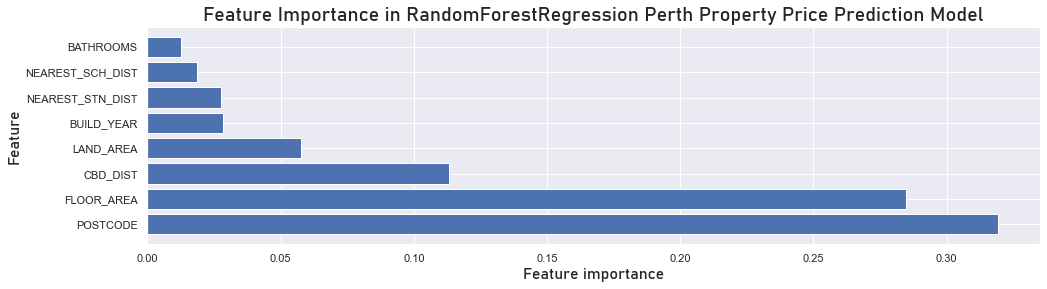

In [26]:
# Create Pandas Series with the 8 most important features 
feature_importance = pd.Series(grid_rf.best_estimator_._final_estimator.feature_importances_, index=houses_df_predictor.columns).nlargest(8)

fig, ax = plt.subplots()

# Set figure size
fig.set_size_inches(16,4)

# Plot feature importances of the RFR model
ax.barh(y = feature_importance.index, width = feature_importance)

# Set labels
ax.set_xlabel('Feature importance', lfont)
ax.set_ylabel('Feature', lfont)
ax.set_title('Feature Importance in RandomForestRegression Perth Property Price Prediction Model', tfont)

plt.show()

In [27]:
# Create a DataFrame showcasing actual values vs predicted values by the model
model_perf_df = pd.DataFrame([y_test.values, y_pred]).transpose().rename(columns = {0:'Actual Price', 1:'Predicted Price'})

# Display DataFrame
model_perf_df.describe().apply(lambda x: x.apply('{0:.2f}'.format)).head(10)

,Actual Price,Predicted Price
count,6732.00,6732.00
mean,635187.03,638984.51
std,351034.73,316752.87
min,53000.00,155367.71
25%,410000.00,424743.59
50%,535500.00,547230.05
75%,760000.00,763778.10
max,2425000.00,2212408.71


### __Insights on Machine Learning Modelling__

- The best machine learning model from the models experimented with is the ensemble learning method RandomForestRegression.

- Fine tuning the model with the hyperparameters in the hyperparameter grid search shows a very slight improvement to the model performance, with a final R-squared value of 0.8096, and Root Mean Squared Error (RMSE) of $153,257.

- The 3 most important features in the model which have larger effect on the <code>PRICE</code> target variable were determined to be <CODE>POSTCODE</CODE>, <CODE>FLOOR_AREA</CODE> and <CODE>CBD_DIST</CODE>.

- When comparing the actual and predicted prices, the Mean, 25th, 50th and 75th percentiles are notably close, however the Min, Max and Std show larger discrepancies. This implies the model typically performs better for observations with commonly observed values, but underperforms on outliers and more extreme data.

### __Visualizing Predicted vs Actual Values__

Lastly, we will create plots that capture the differences between the predicted and actual values to further gauge the model performance and prediction errors.

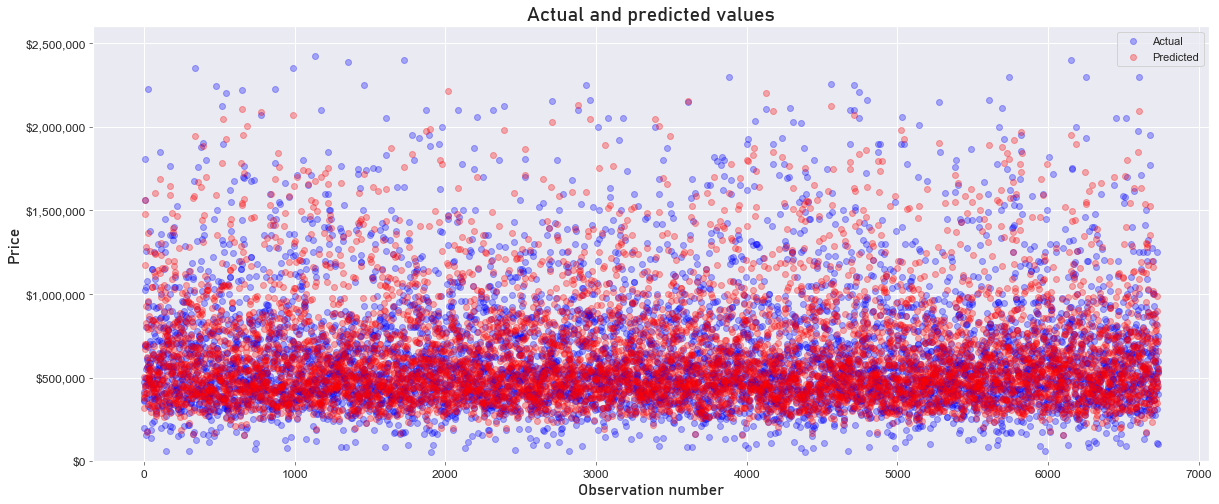

In [28]:
fig, ax = plt.subplots()

# Set figure size
fig.set_size_inches(20,8)

# Plot scatterplots of predicted vs actual values
ax.scatter(x = range(0, y_test.size), y=y_test, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, y_pred.size), y=y_pred, c = 'red', label = 'Predicted', alpha = 0.3)
ax.set_title('Actual and predicted values', tfont)
ax.set_xlabel('Observation number', lfont)
ax.set_ylabel('Price', lfont)

# Format ticks
ax.tick_params(bottom=True, left=True, length=4, width=1, which='major', direction='out', color='grey', labelsize=12)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: '$' + format(int(x),',')))

# Set axis ranges
ax.set_ylim(0, 2600000)

# Create legend to colour code points
ax.legend()

plt.show()

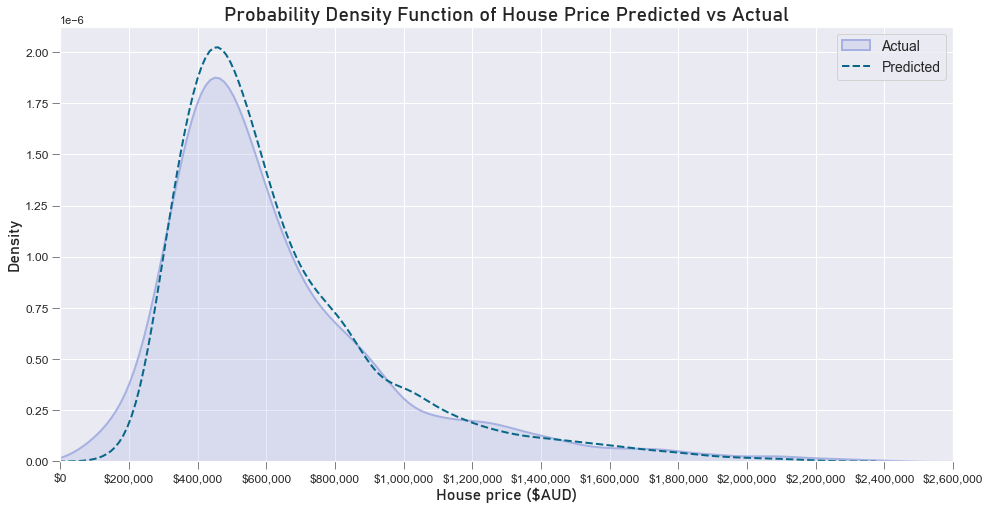

In [29]:
fig, ax = plt.subplots()

# Set figure size
sns.set(rc={'figure.figsize':(20,8)})

# Plot Probability Density Function of actual vs predicted PRICE
ax = sns.kdeplot(y_test, color='#A6B1E1', linewidth=2, fill=True, label='Actual')
ax = sns.kdeplot(y_pred, color='#086788', linewidth=2, linestyle='dashed', label='Predicted')

# Set labels
ax.set_xlabel('House price ($AUD)', lfont)
ax.set_ylabel('Density', lfont)
ax.set_title('Probability Density Function of House Price Predicted vs Actual', tfont)

# Format plot
ax.tick_params(bottom=True, left=True, length=8, width=1, which='major', direction='out', color='grey', labelsize=12)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: '$' + format(round(x), ',')))
ax.locator_params(axis='x', nbins=14)
ax.set_xlim(0, 2600000)

# Add legend for colours of 2 graphs
ax.legend(prop={'size':14})

plt.show()

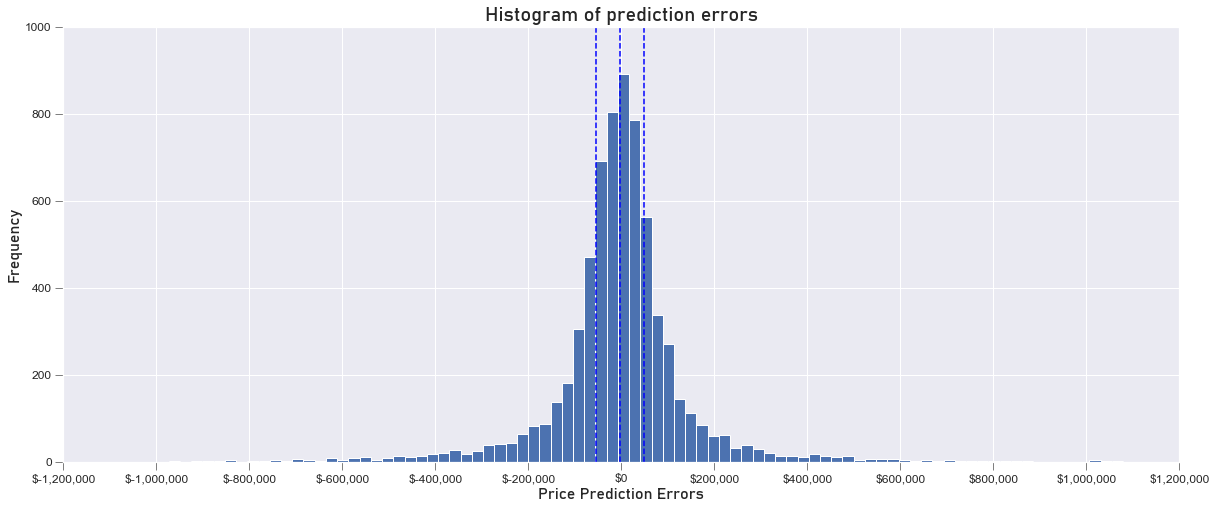

In [30]:
# Calculate errors by subtracting the actual values from the predicted values
diff = y_test - y_pred

fig, ax = plt.subplots()

# Plot histogram of price prediction error 
diff.hist(bins=100)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: '$' + format(round(x), ',')))
ax.set_title('Histogram of prediction errors', tfont)
ax.set_xlabel('Price Prediction Errors', lfont)
ax.set_ylabel('Frequency', lfont)

# Format plot
ax.tick_params(bottom=True, left=True, length=8, width=1, which='major', direction='out', color='grey', labelsize=12)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: '$' + format(round(x), ',')))
ax.locator_params(axis='x', nbins=14)
ax.set_xlim(-1200000, 1200000)
ax.set_ylim(0, 1000)

# Add vertical lines indicating median and interquartile range 
ax.axvline(diff.median(), color='blue', linestyle='dashed', linewidth=1.5)
ax.axvline(diff.quantile(0.25), color='blue', linestyle='dashed', linewidth=1.5)
ax.axvline(diff.quantile(0.75), color='blue', linestyle='dashed', linewidth=1.5)

plt.show()

In [31]:
# Calculate statistical data of errors
pd.Series(diff).describe().head(10).round(2)

count       6732.00
mean       -3797.48
std       152656.21
min      -973028.75
25%       -54237.67
50%        -2271.00
75%        49628.66
max      1441715.79
Name: PRICE, dtype: float64

### __Insights from visualizing Predicted vs Actual values for home Prices__

- The model generally performs better on observations that have more commonly observed values, and the predicted values take on a positively skewed distribution that closely follows the actual price distritbution.

- The model predicts there are more properties with commonly observed price values than there actually are. It also underperforms on observations which take on more extreme lower values, such as house prices between \$0 and $250,000. This could be due to the lack of sufficient observations in this lower price range during training.

- Model prediction errors follow a similar shape to a normal distribution with a mean error of -3,945.46 (which is close to 0 given the range of potential house prices), meaning there is an almost equal amount of positive and negative discrepancies between the predicted and actual values (error values to either side of the mean).

- 68% of errors (within 1 standard deviation of the mean) between the actual and predicted values are between -\$157,162 and $149,272. 

## __Conclusion__

This study has allowed for a deeper look into Perth property prices and the effect features have on these prices through the visualization and re-expression of the data. 

It has reinforced how character homes are on average more expensive than newer homes that may share some of the same features, with the price per square metre of a character home being typically higher than that of a new home of the same size. The year of construction has also been shown to have a weak negative correlation with house price, meaning that older homes generally have slightly higher prices.

The machine learning model developed reveals that <code>POSTCODE</code>, <code>FLOOR_AREA</code> and <code>CBD_DIST</code> are the most important features in informing a property's price. <code>BUILD_YEAR</code> is only the 5th most important feature in the final model, meaning that the location of the house, its size, and its distance from the CBD are generally more telling of a home's price than the home's year of construction. 

The model does have room for improvement, however, especially to reduce its RMSE. Some strategies that could be experimented with involve: creating models specific to suburban or rural areas, training and testing against other model types, removing features that are potentially noisy, engineering new more informative features, or changing the definition of an outlier in the context of the study.

> Thanks

If you made it this far in looking through my project, thank you for your time :)